# Scraping movies by years (produced/released vs. set in)

## 1. Import and define paths

In [1]:
import os, re, pickle, time
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import wikipediaapi as wkapi

In [2]:
produced_data_path = 'data/films_by_produced.csv'
setin_data_path = 'data/films_by_set_in.csv'
processed_data_path = 'data/films_set_in_and_produced.csv'

## 2. Define scraping functions

In [3]:
wk = wkapi.Wikipedia('Data of movies by years (penguins@antarct.ica)', 'en')

In [4]:
def traverse_category(category, output=[], level=0, max_level=1):
    parent = category.title
    for c in category.categorymembers.values():
        output.append(dict(
            title = c.title,
            ns = c.ns,
            pageid = c.pageid,
            level = level,
            parent = parent
        ))
            
        if c.ns == wkapi.Namespace.CATEGORY and level < max_level:
            output = traverse_category(
                c,
                output,
                level=level + 1, 
                max_level=max_level
            )
    return output

In [5]:
def scrape_film_list(category_seed, max_try = 2):
    num_try = 1
    success = False
    t0 = time.time()
    print(f'Scrape {category_seed}')
    while num_try <= max_try and not success:
        try:
            cat_page = wk.page(category_seed)
            cat_tree = traverse_category(cat_page)
            df = pd.DataFrame(cat_tree)
            success = True
        except:
            print('\tElapsed %.2f seconds' %(time.time() - t0))
            print(f'\tError with {category_seed}. Will try again!')
        
        num_try += 1
    print('Elapsed %.2f seconds' %(time.time() - t0))
    return df


## 3. Scrape movies by **produced** year

In [6]:
df_produced = scrape_film_list(
    'Category:Films_by_year', 
    max_try=3
)

Scrape Category:Films_by_year
Elapsed 146.34 seconds


In [7]:
df_produced

title  ns    pageid  level  \
0                 Category:3D films by year  14  47763114      0   
1                    Category:1953 3D films  14  70933910      1   
2                    Category:1954 3D films  14  70933932      1   
3                    Category:1982 3D films  14  70926523      1   
4                    Category:1983 3D films  14  65491608      1   
...                                     ...  ..       ...    ...   
166171                  Category:2025 films  14  74026790      0   
166172                             Avatar 3   0  27442998      1   
166173  Category:2025 science fiction films  14  74026793      1   
166174                  Category:2115 films  14  56366623      0   
166175                     100 Years (film)   0  48973524      1   

                           parent  
0          Category:Films_by_year  
1       Category:3D films by year  
2       Category:3D films by year  
3       Category:3D films by year  
4       Category:3D films by year  
...                           ...  
166171     Category:Films_by_year  
166172        Category:2025 films  
166173        Category:2025 films  
166174     Category:Films_by_year  
166175        Category:2115 films  

[166176 rows x 5 columns]

In [8]:
df_produced['year_produced'] = df_produced['parent'].apply(
    lambda x: int(d['year']) if 
        (d:=re.search('Category\:(?P<year>\d{4})\s+(films)?', x)) is not None
        else None
)

df_produced = (
    df_produced
    .dropna(subset='year_produced')
    .query('ns == 0')
    .astype({'year_produced': 'int'})
    .drop(columns=['parent', 'ns', 'level'])
    .reset_index(drop=True)
)

In [9]:
df_produced

title    pageid  year_produced
0                  Passage de Vénus  47863608           1874
1               The Horse in Motion  26044155           1878
2       Man Walking Around a Corner  14360688           1887
3                  Accordion Player  14360591           1888
4             Roundhay Garden Scene   1082508           1888
...                             ...       ...            ...
161762           Wicked (2024 film)  60455274           2024
161763        Wise Guys (2024 film)  71537782           2024
161764       Witchboard (2024 film)  73430842           2024
161765                     Avatar 3  27442998           2025
161766             100 Years (film)  48973524           2115

[161767 rows x 3 columns]

In [10]:
df_produced.to_csv(produced_data_path, index=False)

## 4. Scrape movies by **set-in** year/decade/century

In [11]:
categories = [
    'Category:Films_by_century_of_setting',
    'Category:Films_by_decade_of_setting',
    'Category:Films_by_year_of_setting'
]

dfs_setin = []
for c in categories:
    dfs_setin.append(scrape_film_list(c, max_try=3))
    
df_setin = pd.concat(dfs_setin, ignore_index=True)

Scrape Category:Films_by_century_of_setting
Elapsed 11.18 seconds
Scrape Category:Films_by_decade_of_setting
Elapsed 20.52 seconds
Scrape Category:Films_by_year_of_setting
Elapsed 82.91 seconds


In [12]:
df_setin

title  ns    pageid  level  \
0                  Category:3D films by year  14  47763114      0   
1                     Category:1953 3D films  14  70933910      1   
2                     Category:1954 3D films  14  70933932      1   
3                     Category:1982 3D films  14  70926523      1   
4                     Category:1983 3D films  14  65491608      1   
...                                      ...  ..       ...    ...   
533442  The Last Days of Pompeii (1950 film)   0  27139182      1   
533443  The Last Days of Pompeii (1959 film)   0  25972799      1   
533444                        Pompeii (film)   0  39083980      1   
533445                 Pompeii: The Last Day   0   1005379      1   
533446                     Up Pompeii (film)   0  22812968      1   

                             parent  
0            Category:Films_by_year  
1         Category:3D films by year  
2         Category:3D films by year  
3         Category:3D films by year  
4         Category:3D films by year  
...                             ...  
533442  Category:Films set in 79 AD  
533443  Category:Films set in 79 AD  
533444  Category:Films set in 79 AD  
533445  Category:Films set in 79 AD  
533446  Category:Films set in 79 AD  

[533447 rows x 5 columns]

### 4.1. Checking a few things

Check the variable `ns`

In [13]:
df_setin.query('parent.str.contains("Films set in")')['ns'].value_counts()

0     32037
14     2136
2         2
Name: ns, dtype: int64

Checking what that `ns=14` are those with title starts with `'Category:'`, which means these should be filtered out

In [14]:
(
    df_setin.query('parent.str.contains("Films set in")')
    .query('ns == 14')
    ['title'].apply(lambda x: x.startswith('Category:'))
    .all()
)

True

Checking what that `ns=0` are those **without** title startswith `'Category:'`. These should be kept

In [15]:
(
    df_setin.query('parent.str.contains("Films set in") and ns == 0')
    ['title'].apply(lambda x: x.startswith('Category:'))
    .any()
)

False

### 4.2. Process and save data

In [16]:
df_setin = pd.concat(dfs_setin, ignore_index=True)

In [17]:
df_setin = (
    df_setin
    .query(
        'parent.str.contains("Films set in")'\
        'and not parent.str.contains("Infamous Decade")'\
        'and ns == 0'
    )
    .drop(columns=['ns','level'])
)

# obtain year/decade/century it is set in
df_setin['year_setin'] = (
    df_setin.pop('parent')
    .str.replace('Category:Films set in ','')
    .str.replace('the ', '')
    .str.replace(' century', '')
)

df_setin = (
    df_setin
    .groupby(['pageid', 'title'])
    .agg(set)
    .reset_index()
)

df_setin['year_setin'] = df_setin['year_setin'].apply(list)

In [18]:
df_setin

pageid                         title                  year_setin
0          3217              Army of Darkness                      [13th]
1          3333         The Birth of a Nation        [1860s, 19th, 1870s]
2          3746                  Blade Runner                      [2019]
3          3837               Blazing Saddles                [1856, 1874]
4          4227                  Barry Lyndon  [1763, 1773, 1780s, 1750s]
...         ...                           ...                         ...
13837  74597836            The Sacrifice Game                      [1971]
13838  74607682    Joachim and the Apocalypse                      [12th]
13839  74612478       The Kitchen (2023 film)                     [2040s]
13840  74619750  Jailer (2023 Malayalam film)                     [1950s]
13841  74621258           Robot Dreams (film)                     [1980s]

[13842 rows x 3 columns]

In [19]:
df_setin.to_csv(setin_data_path, index=False)

## 5. Combine and process

In [20]:
df_films = (
    df_setin
    .merge(df_produced, on=['pageid', 'title'])
    .explode('year_setin')
    .reset_index(drop=True)
)

In [21]:
def convert_non_standard_time(x):
    if isinstance(x, int):
        return dict(value = x, type = 'year')
    if isinstance(x, float):
        return dict(value = x, type = 'year')
    if (value:=re.match('^\d{4}$', x)) is not None:
        value = int(value.group())
        return dict(value = value, type = 'year')
    if (value:=re.search('(\d+)\s*(st|nd|rd|th)', x)) is not None:
        value = int(value.groups()[0]) * 100
        if 'BC' in x:
            value = -value
        else:
            value -= 100
        return dict(value = value, type = 'century')
    if (value:=re.search('(\d+)\s+AD', x)) is not None:
        value = int(value.groups()[0])
        return dict(value = value, type = 'year')
    if (value:=re.search('(\d{4})s', x)) is not None:
        value = int(value.groups()[0])
        return dict(value = value, type = 'decade')

df_year_aux = df_films['year_setin'].apply(convert_non_standard_time)
    

In [22]:
df_films = pd.concat([
    df_films.rename(columns={'year_setin': 'source_year_setin'}),
    (
        pd.DataFrame(df_year_aux.to_list())
        .rename(columns={
            'value': 'year_setin',
            'type': 'year_setin_type'
        })
    )
], axis=1)

In [23]:
df_films['year_setin'].dtype

dtype('int64')

In [24]:
df_films

pageid                         title source_year_setin  \
0          3217              Army of Darkness              13th   
1          3333         The Birth of a Nation             1860s   
2          3333         The Birth of a Nation              19th   
3          3333         The Birth of a Nation             1870s   
4          3746                  Blade Runner              2019   
...         ...                           ...               ...   
20150  74597836            The Sacrifice Game              1971   
20151  74607682    Joachim and the Apocalypse              12th   
20152  74612478       The Kitchen (2023 film)             2040s   
20153  74619750  Jailer (2023 Malayalam film)             1950s   
20154  74621258           Robot Dreams (film)             1980s   

       year_produced  year_setin year_setin_type  
0               1992        1200         century  
1               1915        1860          decade  
2               1915        1800         century  
3               1915        1870          decade  
4               1982        2019            year  
...              ...         ...             ...  
20150           2023        1971            year  
20151           2023        1100         century  
20152           2023        2040          decade  
20153           2023        1950          decade  
20154           2023        1980          decade  

[20155 rows x 6 columns]

In [25]:
df_films.to_csv(processed_data_path,index=False)

## 6. Simple plot

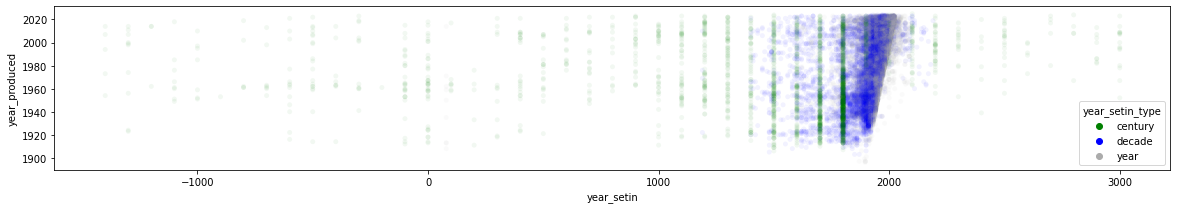

In [26]:
plt.figure(figsize=(20,15))
sns.scatterplot(
    df_films,
    y = 'year_produced',
    x = 'year_setin',
    hue = 'year_setin_type',
    palette={
        'year': '#ababab',
        'decade': 'b',
        'century': 'g'
    },
    s = 25,
    alpha = 0.05,
    edgecolor = 'none',
)
plt.gca().set_aspect(5, 'box')
# plt.xlim([1900, 2000])